In [ ]:
source("helper.R")
library(ngme2)
max_expid<-get_max("Log")+1
exp_name<-"Pricing"
log_dir<-glue("Log/{max_expid}.{exp_name}")
logger=get_logger(log_dir, log_name = "log", debug = TRUE)
futile.logger::flog.info("start experiment", name = "log")

## get logger

use_saudi<-FALSE
seed_random<-123
n=30

futile.logger::flog.info(glue("use_saudi: {use_saudi}"), name = "log")

set.seed(seed_random)

futile.logger::flog.info(glue("use seed: {seed_random}"), name = "log")

futile.logger::flog.info(glue("number of experiments: {n}"), name = "log")

if(!use_saudi){

    data_ori <- as.data.frame(read_csv("data/IFclose.csv"))
    logpt<-log(data_ori$close)
    logreturn <-logpt[2:length(logpt)]-logpt[1:(length(logpt)-1)]
    date <- as.Date(as.character(data_ori$Date[1:(length(data_ori$Date)-1)]), format = "%Y%m%d")
    date_timeindex_ori<-as.numeric(as.POSIXct(date)) 
    date_timeindex <- (date_timeindex_ori - min(date_timeindex_ori))/86400 ## 1 day = 86400 seconds
    data = data.frame(logreturn = logreturn, times = date_timeindex)
    data <- rbind(data, data.frame(logreturn = NA, times = max(date_timeindex):(max(date_timeindex)+31)))
    mesh <- fm_mesh_1d(data$times)
}else{
    data_ori <- as.data.frame(read_csv("data/1180_vol.csv"))
    logpt<-log(data_ori$Close)
    logreturn <-logpt[2:length(logpt)]-logpt[1:(length(logpt)-1)] ## 1 day = 86400 seconds
    date <- data_ori$Date[1:(length(data_ori$Date)-1)]
    date_timeindex_ori<-as.numeric(as.POSIXct(date)) 
    date_timeindex <- (date_timeindex_ori - min(date_timeindex_ori))/86400
    data = data.frame(logreturn = logreturn, times = date_timeindex)
    data <- rbind(data, data.frame(logreturn = NA, times = max(date_timeindex):(max(date_timeindex)+31)))
    mesh <- fm_mesh_1d(data$times)
}



Warning message:
“package ‘INLA’ was built under R version 4.5.0”
Loading required package: Matrix



This is INLA_25.06.07 built 2025-06-11 18:54:45 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


This is rSPDE 2.5.1
- See https://davidbolin.github.io/rSPDE for vignettes and manuals.



INFO [2025-09-10 11:24:17] start experiment
INFO [2025-09-10 11:24:17] use_saudi: FALSE
INFO [2025-09-10 11:24:17] use seed: 123
INFO [2025-09-10 11:24:17] number of experiments: 30


Rows: 1595 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ins_id
dbl (2): Date, close

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [2]:
set.seed(123)

## best fit stochvol IF,2/137.3123/0.5628
## best fit stochvol SR,4/118.271/0.7802

best.rspde.order<-3
best.prior.range.nominal<-85.9432
best.prior.std.dev.nominal<-1.2195









## best fit IF,2/137.3123/0.5628

In [3]:

OU_model <- rspde.matern(
    mesh = mesh,
    parameterization = "matern",
    rspde.order = best.rspde.order,
    prior.range.nominal = best.prior.range.nominal,
    prior.std.dev.nominal = best.prior.std.dev.nominal
  )
    
    formula_OU <- logreturn ~ -1 + Intercept(1)+ field(times, model = OU_model)
fit<-bru(formula_OU, family="stochvol.nig", data = data)
result_fit<- rspde.result(fit, "field", OU_model, parameterization="matern")
summary(result_fit)

Warning message in rspde.result(fit, "field", OU_model, parameterization = "matern"):
“the mean or mode of nu is very close to nu.upper.bound, please consider increasing nu.upper.bound, and refitting the model.”


,mean,sd,0.025quant,0.5quant,0.975quant,mode
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
std.dev,0.633152,0.0871077,0.478630,0.627525,0.820184,0.617075
range,91.369900,24.3958000,52.685400,88.261300,147.937000,82.397900
nu,1.437830,0.4223520,0.486295,1.529320,1.971120,1.939400


In [8]:
fit

inlabru version: 2.13.0
INLA version: 25.06.07
Components:
Intercept: main = linear(1), group = exchangeable(1L), replicate = iid(1L), NULL
field: main = cgeneric(times), group = exchangeable(1L), replicate = iid(1L), NULL
Observation models:
  Family: 'stochvol.nig'
    Tag: <No tag>
    Data class: 'data.frame'
    Response class: 'numeric'
    Predictor: logreturn ~ .
    Additive/Linear: TRUE/TRUE
    Used components: effects[Intercept, field], latent[]
Time used:
    Pre = 0.616, Running = 6.14, Post = 0.441, Total = 7.2 
Fixed effects:
            mean    sd 0.025quant 0.5quant 0.975quant   mode kld
Intercept -8.918 0.142     -9.199   -8.918     -8.635 -8.918   0

Random effects:
  Name	  Model
    field CGeneric

Model hyperparameters:
                                      mean    sd 0.025quant 0.5quant 0.975quant
skewness parameter for stochvol-nig  0.017 0.067     -0.116    0.017      0.147
shape parameter for stochvol-nig     1.357 0.153      1.133    1.332      1.725
Theta1 

In [11]:
attributes(fit)

$names
 [1] "names.fixed"                 "summary.fixed"              
 [3] "marginals.fixed"             "summary.lincomb"            
 [5] "marginals.lincomb"           "size.lincomb"               
 [7] "summary.lincomb.derived"     "marginals.lincomb.derived"  
 [9] "size.lincomb.derived"        "mlik"                       
[11] "cpo"                         "gcpo"                       
[13] "po"                          "waic"                       
[15] "residuals"                   "model.random"               
[17] "summary.random"              "marginals.random"           
[19] "size.random"                 "summary.linear.predictor"   
[21] "marginals.linear.predictor"  "summary.fitted.values"      
[23] "marginals.fitted.values"     "size.linear.predictor"      
[25] "summary.hyperpar"            "marginals.hyperpar"         
[27] "internal.summary.hyperpar"   "internal.marginals.hyperpar"
[29] "offset.linear.predictor"     "model.spde2.blc"            
[31] "summary.spde2.blc"           "marginals.spde2.blc"        
[33] "size.spde2.blc"              "model.spde3.blc"            
[35] "summary.spde3.blc"           "marginals.spde3.blc"        
[37] "size.spde3.blc"              "logfile"                    
[39] "misc"                        "dic"                        
[41] "mode"                        "joint.hyper"                
[43] "nhyper"                      "version"                    
[45] "Q"                           "graph"                      
[47] "ok"                          "cpu.intern"                 
[49] "cpu.used"                    "all.hyper"                  
[51] ".args"                       "call"                       
[53] "model.matrix"                "bru_iinla"                  
[55] "bru_timings"                 "bru_info"                   

$class
[1] "bru"   "iinla" "inla"

In [13]:
fit$summary.hyperpar


,mean,sd,0.025quant,0.5quant,0.975quant,mode
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
skewness parameter for stochvol-nig,0.0166741,0.0668323,-0.1157567,0.01696835,0.1473856,0.01819578
shape parameter for stochvol-nig,1.3572487,0.1532709,1.1333431,1.33184426,1.7245150,1.28342592
Theta1 for field,-0.4664527,0.1379647,-0.7392042,-0.46606047,-0.1959873,-0.46443009
Theta2 for field,4.4803698,0.2644526,3.9599069,4.48031125,5.0011722,4.48006872
Theta3 for field,1.2891343,1.3831149,-1.1529973,1.20706649,4.2554670,0.80392622


In [14]:
inla.doc("stochvol.nig")

In [ ]:
delta, mu, nu, sigma

In [9]:
attr(fit)

ERROR: Error in attr(fit): either 2 or 3 arguments are required


In [4]:
library(lubridate)
# 假设 date 是一个 Date 向量
#date <- as.Date(c("2025-07-10", "2025-07-15", "2025-07-20"))  # 示例数据

# 获取最后一天
last_day <- max(date)
# 生成从 next_day 开始到下个月同一天之前的所有日期
next_day <- last_day + 1
end_day <- as.Date("2024-05-17")

# 生成完整序列
all_days <- seq.Date(from = next_day, to = end_day, by = "day")

# 只保留非周末（即工作日）
biz_days <- all_days[!weekdays(all_days) %in% c("Saturday", "Sunday")]
date_timeindex_new<-as.numeric(as.POSIXct(biz_days)) 
date_timeindex_new <- (date_timeindex_new - min(date_timeindex_ori))/86400 ## 1 day = 86400 seconds
# 保存到数据框
new_data <- data.frame(times = date_timeindex_new)



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [5]:
discount_factor<- 1.02**(-21/252)

This is ngme2 of version 0.7.0
- See our homepage: https://davidbolin.github.io/ngme2 for more details.


Attaching package: ‘ngme2’


The following object is masked from ‘package:rSPDE’:

    cross_validation


The following object is masked from ‘package:INLA’:

    f


The following object is masked from ‘package:stats’:

    ar




In [7]:
?rnig

nig                   package:ngme2                    R Documentation

_T_h_e _N_o_r_m_a_l _I_n_v_e_r_s_e-_G_a_u_s_s_i_a_n (_N_I_G) _D_i_s_t_r_i_b_u_t_i_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     Density, distribution function, quantile function and random
     generation for the normal inverse-Gaussian distribution with
     parameters ‘p’, ‘a’ and ‘b’.

_U_s_a_g_e:

     dnig(x, delta, mu, nu, sigma, h = NULL, log = FALSE)
     
     rnig(n, delta, mu, nu, sigma, h = NULL, seed = 0)
     
     pnig(q, delta, mu, nu, sigma, h = NULL, lower.tail = TRUE, log.p = FALSE)
     
     qnig(p, delta, mu, nu, sigma, h = NULL, lower.tail = TRUE, log.p = FALSE)
     
_A_r_g_u_m_e_n_t_s:

    x, q: vector of quantiles.

   delta: A numeric value for the location parameter.

      mu: A numeric value for the shift parameter.

      nu: A numeric value for the shape parameter.

   sigma: A numeric value for the scaling parameter.

       h: A

In [ ]:
delta_S_T<-generate(fit, new_data, ~ exp((field+Intercept)/2), n.samples = 100000)

In [ ]:
library("ngme2")

ERROR: Error in library("ngme"): there is no package called ‘ngme’


In [ ]:
remotes::install_github("davidbolin/ngme2", ref = "devel")

Skipping 7 packages not available: RcppEigen, Rcpp, testthat, gridExtra, fmesher, ggplot2, rlang



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpWXeUsV/remotes15a22e1fa9c0cc/davidbolin-ngme2-d70c4eb/DESCRIPTION’ ... OK
* preparing ‘ngme2’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
'
'
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
'
'
* building ‘ngme2_0.7.0.tar.gz’



Installing package into ‘/home/jianj0c/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘/tmp/RtmpWXeUsV/file15a22e70fc7316/ngme2_0.7.0.tar.gz’ had non-zero exit status”


In [ ]:
library(GeneralizedHyperbolic)

alpha <- 1.357   # shape
beta  <- 0.017   # skewness
mu    <- 0       # 可以设为0（对称 around 0）
delta <- as.vector(delta_S_T)   # 每个点的尺度参数

rand_mat <- matrix(
  rnig(length(delta), mu = mu, delta = delta, alpha = alpha, beta = beta),
  nrow = nrow(delta_S_T), ncol = ncol(delta_S_T)
)


ERROR: Error in library(GeneralizedHyperbolic): there is no package called ‘GeneralizedHyperbolic’


In [ ]:

dof <- fit$summary.hyperpar$mean[1]

# t分布缩放因子 (保持期望标准差 = delta_S_T)
scale <- as.vector(delta_S_T) / sqrt(dof / (dof - 2))

# 生成随机矩阵
random_return_rate <- matrix(
  rt(length(delta_S_T), df = dof) * scale,
  nrow = nrow(delta_S_T),
  ncol = ncol(delta_S_T)
)

In [ ]:
return_rate_to_end<-exp(colSums(random_return_rate))
simulated_final_prices <- data_ori$close[length(data_ori$close)] * return_rate_to_end

In [ ]:
data_ori$close[length(data_ori$close)]

[1] 3540.547

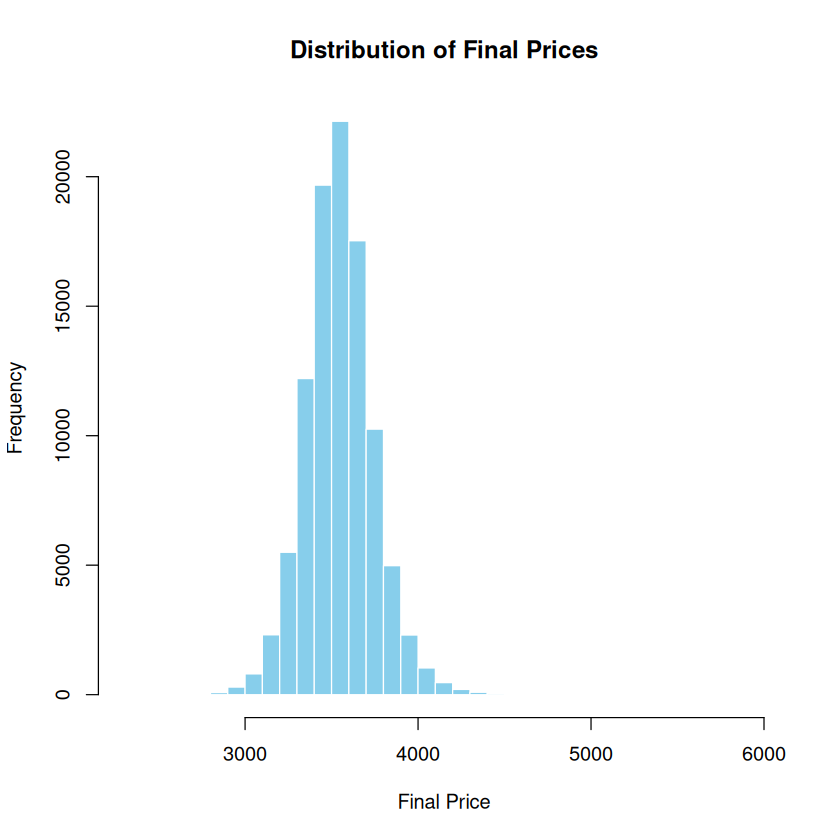

In [ ]:
par(bg = "white")
hist(simulated_final_prices, 
     breaks = 50, col = "skyblue", border = "white",
     main = "Distribution of Final Prices", xlab = "Final Price")

In [ ]:
expected_payoff <- function(sim_prices, K, type = c("call", "put"), discount_factor = 1) {
  # sim_prices: simulated prices
  # K: strike price
  # type: "call" or "put"
  # discount_factor: discount factor, default=1 (if you need e^{-rT} outside)
  
  type <- match.arg(type)
  
  if (type == "call") {
    payoff <- pmax(sim_prices - K, 0)
  } else {
    payoff <- pmax(K - sim_prices, 0)
  }
  
  return(mean(payoff) * discount_factor)
}

In [ ]:
pricing_values<-list()



call_records<-as.data.frame(read_csv("data/calls_records.csv"))
put_records<-as.data.frame(read_csv("data/put_records.csv"))



for (i in 1:nrow(call_records)){
    strike<-call_records$strike[i]
    call_price<-expected_payoff(simulated_final_prices, K = strike, type = "call", discount_factor = discount_factor)
    pricing_values$call_records[i]<-call_price
}

for (i in 1:nrow(put_records)){
    strike<-put_records$strike[i]
    put_price<-expected_payoff(simulated_final_prices, K = strike, type = "put", discount_factor = discount_factor)
    pricing_values$put_records[i]<-put_price
}


call_records$theoretical_price<-pricing_values$call_records
put_records$theoretical_price<-pricing_values$put_records



write.csv(call_records, glue("{log_dir}/calls_records_with_theoretical_price.csv"))
write.csv(put_records, glue("{log_dir}/put_records_with_theoretical_price.csv"))






Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): price, strike

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): price, strike

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
find_market_col <- function(df) {
  cand <- c("market_price", "price", "close", "mid")
  hit <- cand[cand %in% names(df)]
  if (length(hit) == 0) stop("未找到市场价格列，请在 cand 中加入正确列名。已有列：", paste(names(df), collapse=", "))
  hit[1]
}
plot_prices <- function(df, title = "Calls", xlab = "Strike", ylab = "Price", underlying = NULL) {
  # 选择市场价格列
  mcol <- find_market_col(df)

  # 仅保留需要列并去 NA
  keep <- c("strike", mcol, "theoretical_price")
  df2 <- df[keep]
  df2 <- df2[complete.cases(df2), ]

  # 按 strike 排序
  ord <- order(df2$strike)
  x  <- df2$strike[ord]
  yM <- df2[[mcol]][ord]              # 市场价格
  yT <- df2$theoretical_price[ord]    # 理论价格

  # 确定坐标范围
  yr <- range(c(yM, yT), finite = TRUE)

  # 画图（白底）
  par(bg = "white")
  plot(x, yM, type = "l", lwd = 2,
       col = rgb(0,0,1,0.6),             # 半透明蓝色
       xlab = xlab, ylab = ylab,
       main = title, ylim = yr, cex.axis=1.2, cex.lab=1.2, cex.main=1.3)
  lines(x, yT, lwd = 2, lty = 2,
        col = rgb(1,0,0,0.6))            # 半透明红色

  # 如果提供了 underlying，就画一条竖线
  if (!is.null(underlying)) {
    abline(v = underlying, col = "black", lty = 3, lwd = 2)
  }

  legend("topleft",
         legend = c("Market", "Theoretical", if (!is.null(underlying)) "Underlying" else NULL),
         lwd = c(2, 2, if (!is.null(underlying)) 2 else NULL),
         lty = c(1, 2, if (!is.null(underlying)) 3 else NULL),
         col = c(rgb(0,0,1,0.6), rgb(1,0,0,0.6), if (!is.null(underlying)) "black" else NULL),
         bty = "n")
}


# --- 分两幅图显示：左边 Call，右边 Put ---
png(glue( "{log_dir}/calls_puts.png"), width=2000, height=1000, res=200)  # 像素宽高
op <- par(mfrow = c(1, 2), mar = c(4, 4, 3, 1), cex=1.2)
plot_prices(call_records, title = "Call: Market vs Theoretical", xlab = "Strike", ylab = "Price",underlying=data_ori$close[length(data_ori$close)])
plot_prices(put_records,  title = "Put: Market vs Theoretical",  xlab = "Strike", ylab = "Price",underlying=data_ori$close[length(data_ori$close)])
par(op)
dev.off()

pdf 
  2